# Installing Dependencies

In [4]:
!apt-get -qq -y install libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet 
!pip -q install pyopengl
!pip -q install pyvirtualdisplay
!pip -q install stable-baselines3
!pip -q install box2d-py
!pip -q install gym[Box_2D]

In [5]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
import random
from gym import wrappers

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
# os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

import matplotlib.animation
import numpy as np
from IPython.display import HTML

# Note, you may get a few warnings regarding Tensorflow and xdpyinfo, these are to be expected
import itertools

#OpenAI Gym

Gym is a toolkit for developing and comparing reinforcement learning algorithms. It makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or PyTorch.

In this notebook, we will have a quick introduction to OpenAI Gym and code-up one example environment named "MountainCar".

**We strongly recommend looking over the ["Getting Started" documentation](https://gym.openai.com/docs/) before working on this worksheet.**

# Lunar Lander Environment
We are trying to land a robot on the moon! 

From OpenAI Gym docs:
Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.


>The observation space is 6 dimensional`:
- X position
- Y position
- X velocity
- Y velocity
- θ angle
- ω angular velocity
- bool: left leg on gound
- bool: right leg on ground

>There are four possible actions of type `Discrete(4)`:
- 0: Do nothing
- 1: Fire left engine
- 2: Fire main engine
- 3: Fire right engine


Let's now create the environment from gym. 

In [6]:
# Initialize the environment
np.random.seed(0)
env = gym.make('LunarLander-v2')
print(env.observation_space) # This is the state representation
print(env.action_space) # These are the available actions

Box(-inf, inf, (8,), float32)
Discrete(4)


In order to interact with the environment, we're going to use the following line of code in a loop to represent one environment step

```observation, reward, done, info = env.step(action)``` 

Here, we pass in an action to the environment and it will update some internal variables and produce the new state (observation), the reward collected at that timestep, whether the simulation has been completed, and then some extra environment specific info. 

We can use this call in a for loop to simulate a complete episode or rollout. 

In [7]:
# Helper functions
def play_once(env, render=False, verbose=False):
    '''
    Run the simulation for 1 episode
    '''
    frames = []
    observation = env.reset()
    episode_reward = 0.
    for step in itertools.count():
        if render:
            frames.append(env.render(mode = 'rgb_array'))
        action = get_action(observation)
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            break
    if verbose:
        print('got {} rewards in {} steps'.format(
                episode_reward, step + 1))
    return episode_reward, frames


## The Simulation
Our task is to develop a policy -- a mapping from the robot's current state to an action (`do nothing`, `thrust left`, `thrust up`, `thrust right`) that is evaluated at each timestep. The `play_once` function above will call a function `get_action` to get the action that we want to apply to the car given its current state.

Let's start with a dumb policy, simply picking a random action amongst the available options. 

In [8]:
def get_action(observation):
    # TODO: Pick a random action
    action = env.action_space.sample()
    return action

In [9]:
# run the simulation
episode_rewards, frames = play_once(env, render=True, verbose=True)

got -225.02165654548537 rewards in 74 steps


In order to see what happened, we can use the following code to generate a video from the frames of the rollout. 

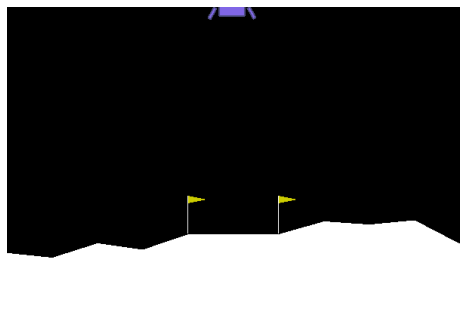

In [10]:
# render the frames
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())


# Reinforcement Learning Policy

Ultimately, we want to create a much better policy than a random action from the observation. Clearly, we can see that given the 8 observation variables, picking an action is hard. In order to be able to solve this task, we will use a powerful algorithm, `A2C (Asynchronous Actor-Critic)`, from a large collection of actively maintained RL algorithms, `stable baselines`.

Let's start by creating the model and then training it for a number of epochs. 


In [11]:
from stable_baselines3 import A2C

# TODO: Create RL Model and train
model  = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=25000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 113      |
|    ep_rew_mean        | -276     |
| time/                 |          |
|    fps                | 472      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.18    |
|    explained_variance | 0.0272   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -13.5    |
|    value_loss         | 65.3     |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 108       |
|    ep_rew_mean        | -333      |
| time/                 |           |
|    fps                | 516       |
|    iterations         | 200       |
|    time_e

That was quite simple! We simply need to invoke the model and then train the model using 2 lines of code. Naturally, there's a number of hyperparameters as well as other algorithms available, so if you want to learn more or experiment the documentation is available [here](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html)


Now let's see how our model does:

In [12]:
def play_once(env, render=False, verbose=False):
    '''
    Run the simulation for 1 episode
    '''
    frames = []
    observation = env.reset()
    episode_reward = 0.
    for step in itertools.count():
        if render:
            frames.append(env.render(mode = 'rgb_array'))
        
        # TODO: use our trained model to produce an action from the observation
        action, _states = model.predict(observation)
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            break
    if verbose:
        print('got {} rewards in {} steps'.format(
                episode_reward, step + 1))
    return episode_reward, frames

# run the simulation
episode_rewards, frames = play_once(env, render=True, verbose=True)

got -38.5953068856681 rewards in 167 steps


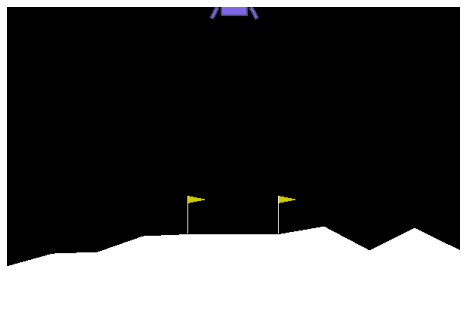

In [13]:
# render the frames
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())